Выполнила: Романенко Александра

Вся эта домашка отчасти мой крик о помощи, потому что надо заранее начинать, конечно, но я болела

## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import models
device = 'cuda'


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.rand(2, 1)
y = torch.rand(2, 1)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [3]:
x * y

tensor([[0.2597],
        [0.3967]])

In [4]:
torch.empty(2, 1, out=(x * y))

tensor([[0.2597],
        [0.3967]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [5]:
def relu_forward(x):
    x[x < 0] = 0
    return x

assert torch.all(F.relu(x) == relu_forward(x))

In [6]:
relu_forward(x)

tensor([[0.6743],
        [0.4567]])

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [7]:
def elu_forward(x):
    x[x < 0] = 1 - torch.exp((x[x < 0]))
    return x

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [8]:
def lrelu_forward(x, alpha):
    x[x < 0] = x[x < 0] * alpha
    return x

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [9]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [10]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [11]:
def swish(x):
    return x * torch.sigmoid(x)

In [12]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [101]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [124]:
class Adam(InClassOptimizer): # кмк у меня получается скорее ребро Адама (или даже его костыль)
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        self.m = dict()
        self.v = dict()

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, 
                                         group['params']):
          # градиент и сразу норма градиента для diag(ggT)
          d_param = param.grad
          d_norm = d_param ** 2

          # теперь нужно проверить, есть ли уже состояние наших параметров, если нет - записать их
          param_state = self.state[param]
          if "buffer_m" not in param_state:
            param_state["buffer_m"] = (1 - beta_1) * d_param # предполагаем, что, если не было, то были нули, поэтому без первого слагаемого
          else:
            param_state["buffer_m"] = beta_1 * param_state["buffer_m"] + (1 - beta_1) * d_param # обновили значение для m на этом шаге
          if "buffer_v" not in param_state:
            param_state["buffer_v"] = (1 - beta_2) * d_norm # предполагаем, что, если не было, то были нули, поэтому без первого слагаемого
          else:
            param_state["buffer_v"] = beta_2 * param_state["buffer_v"] + (1 - beta_2) * d_norm # обновили значение для v на этом шаге
          if 't' not in param_state: # смотрим на номер шага для подсчета параметров с шапочкой дальше :)
            param_state['t'] = 1
          else:
            param_state['t'] += 1
          m_hat =  param_state["buffer_m"] / (1 - beta_1 ** param_state['t'])
          v_hat = param_state["buffer_v"] / (1 - beta_2 ** param_state['t'])

          param.add_(-lr * m_hat / torch.sqrt(v_hat + eps))

          

    def _get_adam_buffer(self, param): # На семинаре мы написали реализацию адаград ьез таких функций, поэтому я немного не разобралась и решила сделать как на семе
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        pass

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        pass

Воспользуемся кодом из семинара для встроенного Адама и чеков

In [110]:
from sklearn.datasets import make_regression


def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(228)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )


def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        print(f'Iteration {i} loss:', output.item())

In [126]:
 lr=0.001

In [129]:
model = get_model()
optim = Adam(model.parameters(), lr)
check_optimizer(model, optim, 5)

Iteration 0 loss: 15799.87890625
Iteration 1 loss: 15798.77734375
Iteration 2 loss: 15797.6748046875
Iteration 3 loss: 15796.572265625
Iteration 4 loss: 15795.4716796875


In [130]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr)
check_optimizer(model, optim, 5)

Iteration 0 loss: 15799.87890625
Iteration 1 loss: 15798.77734375
Iteration 2 loss: 15797.6748046875
Iteration 3 loss: 15796.572265625
Iteration 4 loss: 15795.4716796875


Стоили ли усилия этого...

Апдейт того, что совпадение должно быть точным в чате был ОЧЕНЬ поздно, поэтому я положила все слезы на исправления этого адама:(


**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [160]:
w = torch.empty(784, 10, dtype=float)
weights = w.add(torch.FloatTensor(784, 10).uniform_(-np.sqrt(6) / (28 * 28 + 10) ** (1 / 2), np.sqrt(6) / (28 * 28 + 10) ** (1 / 2))).requires_grad_()
intercept = torch.zeros(1, 10,  dtype=float, requires_grad=True)

In [161]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [2]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train, batch_size=16,
                                          shuffle=True, num_workers=1)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval, batch_size=16,
                                          shuffle=True, num_workers=1)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    pass

In [ ]:
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [4]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(0, 40):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Epoch:', epoch)
        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

Для **первой модели** возьмем три последовательных сверточных блока. Чтобы бороться с переобучением, возможным при большем числе последоватльных блоков, добавим дропаут в двух из них и после одного из полносвязных слоев, кроме того, добавим батчнорм для ускорения и стабилизации модели. Замечу также, что в двух блоках вместо релу использовалась сигмоида, что позволит сравнить разные функции активации в моделях.

In [120]:
first_model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.Sigmoid(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(576, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax()
)
first_model.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sigmoid()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sigmoid()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Sigmoid()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.2, inplace=False)
  (15): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

Поскольку разрешено сделать одну полностью полносвязную модель, реализуем такую во **второй модели**, не будем перегружать ее слоями и добавлять дропауты чтобы сравнить качество на выходе с более сложными моделями

In [39]:
second_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)
second_model.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=400, bias=True)
  (2): ReLU()
  (3): Linear(in_features=400, out_features=200, bias=True)
  (4): ReLU()
  (5): Linear(in_features=200, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=10, bias=True)
  (8): Softmax(dim=1)
)

Теперь заморочимся с **третьей моделью**... (Честно, я думала я сюда не дойду, поэтому сдвинула этот класс в конец, но кто не рискует, то не пьет, а после этой домашки выпить захочется). Для реализации накидаем блоков в класс и потом применим их.

In [90]:
mod(imgs[None,:,:,:]).shape

torch.Size([1, 61952])

In [73]:
imgs[None,:,:,:].shape

torch.Size([1, 1, 28, 28])

In [89]:
mod = nn.Sequential(
    nn.Conv2d(1, 32, 7),
    nn.BatchNorm2d(32),
    nn.Sigmoid(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.Sigmoid(),
    nn.Conv2d(32, 128, 3, padding=1),
    nn.BatchNorm2d(128),
                                    nn.Sigmoid(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.Sigmoid(),
                                    nn.Flatten()
)

In [91]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.layer1 = nn.Conv2d(1, 32, 7)
        self.batch128 = nn.BatchNorm2d(128)
        self.batch32 = nn.BatchNorm2d(32) # прописываем методы, чтобы накидывать их потом между слоями
        self.drop = nn.Dropout(0.2)
        self.soft = nn.Softmax()

        self.ac_func1 = nn.ReLU() # прописываем несколько функций активации на будущее
        self.ac_func2 = nn.Sigmoid()
        self.ac_func3 = nn.ELU()

        self.layer2 = nn.Sequential( # накидываем последовательные слои с сиквеншлом
                                    nn.Conv2d(32, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.Sigmoid()
                                    )
        self.layer3 = nn.Sequential( # накидываем последовательные слои с сиквеншлом
                                    nn.Conv2d(32, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.Sigmoid(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.Sigmoid()
                                    )
        
        
        # для полносвязных слоев пропишем линеар

        self.linear1 = nn.Linear(61952, 1000)
        self.linear2 = nn.Linear(1000, 10)
        self.flat = nn.Flatten()
        
    def forward(self, x):

      # сформируем порядок всего как в семинаре

      x = self.layer1(x)
      x = self.batch32(x)
      x = self.ac_func2(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.drop(x)
      x = self.flat(x) # torch.Size([1, 61952]) выходит при такой последовательности
      x = self.linear1(x)
      x = self.ac_func2(x)
      x = linear2(x)
      x = self.soft
      return x

In [92]:
third_model = Model3()
third_model.to(device)

Model3(
  (layer1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (batch128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (soft): Softmax(dim=None)
  (ac_func1): ReLU()
  (ac_func2): Sigmoid()
  (ac_func3): ELU(alpha=1.0)
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmo

In [5]:
imgs, lbl = fashion_mnist_train.__getitem__(1)

## **Первая модель:)**

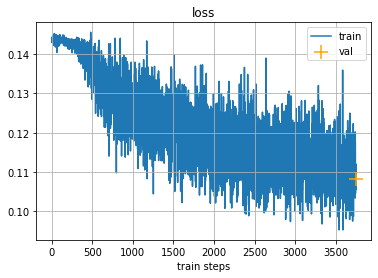

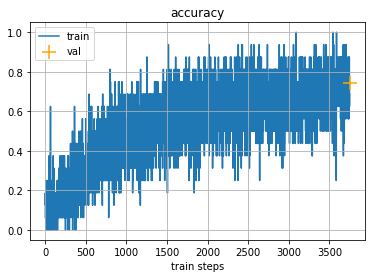

Epoch: 0
Train loss: 0.12157906624476116
Train acc: 0.5328666666666667
Val loss: 0.10812704384326935
Val acc: 0.7421


KeyboardInterrupt: ignored

In [121]:
#1 SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(first_model.parameters(), lr=0.001, momentum=0.9)

train_model(first_model, criterion, optimizer, train_dataloader, eval_dataloader)

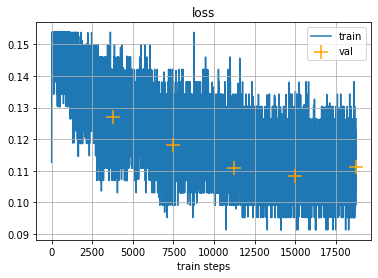

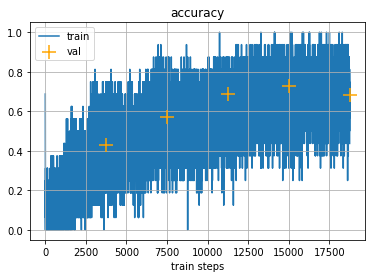

Epoch: 4
Train loss: 0.11079645397265753
Train acc: 0.6881666666666667
Val loss: 0.11113967190980911
Val acc: 0.6831


KeyboardInterrupt: ignored

In [122]:
#1 RMS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(first_model.parameters(), alpha = 0.9, lr = 0.001, momentum=0.9)

train_model(first_model, criterion, optimizer, train_dataloader, eval_dataloader)

## **Вторая модель:)**



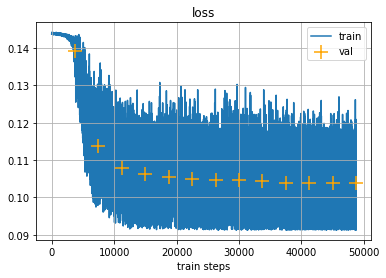

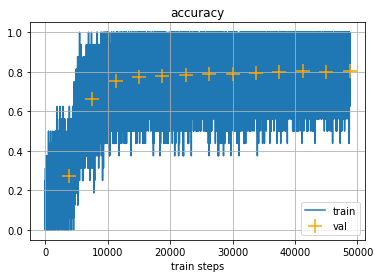

Epoch: 12
Train loss: 0.10314974612196287
Train acc: 0.8132833333333334
Val loss: 0.10376506679058074
Val acc: 0.8037


KeyboardInterrupt: ignored

In [40]:
# SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(second_model.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCH=40

train_model(second_model, criterion, optimizer, train_dataloader, eval_dataloader)

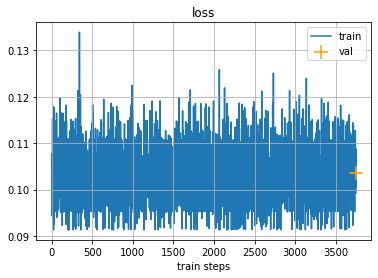

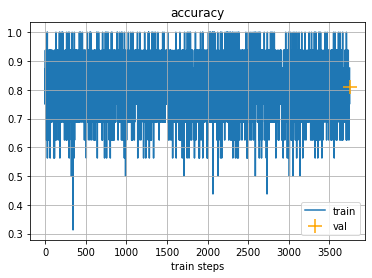

Epoch: 0
Train loss: 0.10291726392507553
Train acc: 0.8166
Val loss: 0.10351072080135346
Val acc: 0.8083


KeyboardInterrupt: ignored

In [41]:
# RMS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(second_model.parameters(), alpha = 0.9, lr = 0.001, momentum=0.9)
NUM_EPOCH=40

train_model(mbase, criterion, optimizer, train_dataloader, eval_dataloader)

## **Третья модель:)**


In [93]:
# SGD

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(third_model.parameters(), lr=0.001, momentum=0.9)

train_model(third_model, criterion, optimizer, train_dataloader, eval_dataloader)

RuntimeError: ignored